In [23]:
#!pip install numpy pandas tqdm matplotlib sentence-transformers scikit-learn tensorflow

In [24]:
# Importing the required libraries

import sqlite3
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError

In [25]:
# Loading the data

df_train = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Obtaining the embeddings for the text data

fine_tuned_model = SentenceTransformer("avsolatorio/GIST-large-Embedding-v0")

text_embeddings = []
for text in tqdm(df_train['text'].tolist(), total=len(df_train)):
    text_embeddings.append(fine_tuned_model.encode(text, convert_to_tensor=False))


df_train['text_embeddings'] = text_embeddings
print(df_train.info())

# Connect to the SQLite database
conn = sqlite3.connect('df_train_mxbai.db')
cursor = conn.cursor()

# Create the table with the specified columns
cursor.execute('''
    CREATE TABLE IF NOT EXISTS embeddings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        keyword TEXT,
        location TEXT,
        text TEXT,
        target INTEGER,
        text_embeddings BLOB
    )
''')

conn.commit()

# Insert data into the table
for idx, (keyword, location, text, target, text_emb) in enumerate(zip(df_train['keyword'], df_train['location'], df_train['text'], df_train['target'], text_embeddings)):
    text_emb_np = text_emb
    cursor.execute('''
        INSERT INTO embeddings (keyword, location, text, target, text_embeddings)
        VALUES (?, ?, ?, ?, ?)
    ''', (keyword, location, text, target, text_emb_np.tobytes()))

conn.commit()
conn.close()

In [27]:
# Load the embeddings from the vector database
def load_embeddings(db_path):
    conn = sqlite3.connect(db_path)
    
    query = 'SELECT * FROM embeddings'
    result = conn.execute(query).fetchall()
    
    columns = ['id', 'keyword', 'location', 'text', 'target', 'text_embeddings']
    df = pd.DataFrame(result, columns=columns)
    
    df['text_embeddings'] = df['text_embeddings'].apply(lambda x: np.frombuffer(x, dtype=np.float32))
    
    conn.close()
    
    return df

db_path = 'df_train_gist_large.db'
training_df = load_embeddings(db_path)
training_df.head()

,id,keyword,location,text,target,text_embeddings
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,"[-0.034164596, 0.046837937, -0.014265966, 0.03..."
1,2,None,None,Forest fire near La Ronge Sask. Canada,1,"[0.00902399, 0.038330305, -0.029241897, 0.0925..."
2,3,None,None,All residents asked to 'shelter in place' are ...,1,"[-0.020227991, 0.03948766, -0.026386732, 0.030..."
3,4,None,None,"13,000 people receive #wildfires evacuation or...",1,"[0.016071625, 0.025278784, 0.00890531, 0.07919..."
4,5,None,None,Just got sent this photo from Ruby #Alaska as ...,1,"[0.05407779, 0.013074751, -0.025554547, 0.0623..."


In [28]:
training_df = training_df.drop_duplicates(subset='text')

In [29]:
# Load Data 
text_embeddings = np.array(training_df['text_embeddings'].tolist())
targets = np.array(training_df['target'].tolist())

# Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(text_embeddings, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Build the Model
model = Sequential([
    Input(shape=(text_embeddings.shape[1],)),
    Dense(528),
    ReLU(),
    Dense(256),
    ReLU(),
    Dense(128),
    ReLU(),
    Dense(64),
    ReLU(),
    Dense(32),
    ReLU(),
    Dense(1)
])

# Compile the Model
#optimizer = RMSprop(learning_rate=0.01)
#optimizer = Adam(learning_rate=0.0001)
#optimizer = SGD(learning_rate=0.001)
optimizer = Adagrad(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=MeanSquaredError(),  
              metrics=[BinaryAccuracy()])

# Train the Model
history = model.fit(X_train, y_train, epochs= 50, validation_data=(X_val, y_val))


# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - binary_accuracy: 0.5717 - loss: 0.3550 - val_binary_accuracy: 0.5667 - val_loss: 0.2569
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5853 - loss: 0.2447 - val_binary_accuracy: 0.5667 - val_loss: 0.2416
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.5829 - loss: 0.2375 - val_binary_accuracy: 0.5667 - val_loss: 0.2378
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.5795 - loss: 0.2345 - val_binary_accuracy: 0.5747 - val_loss: 0.2336
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.5849 - loss: 0.2301 - val_binary_accuracy: 0.5907 - val_loss: 0.2283
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - binary_accuracy: 0.6085 - loss: 0.2241 - val_binary_accuracy: 0.6360 - val_loss: 0.2219
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.6534 - loss: 0.2177 - val_binary_accuracy: 0.7093 - val_loss: 0.2140
Epoch 

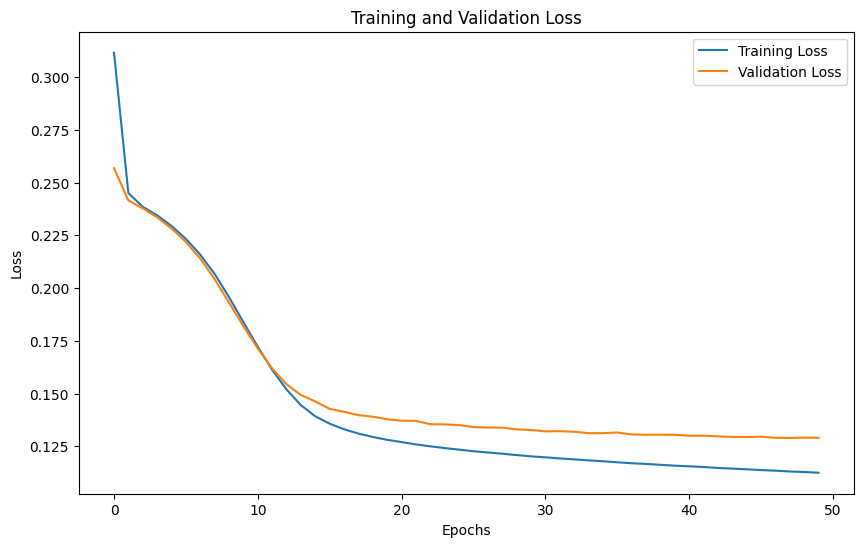

In [30]:
# Plot of the Losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

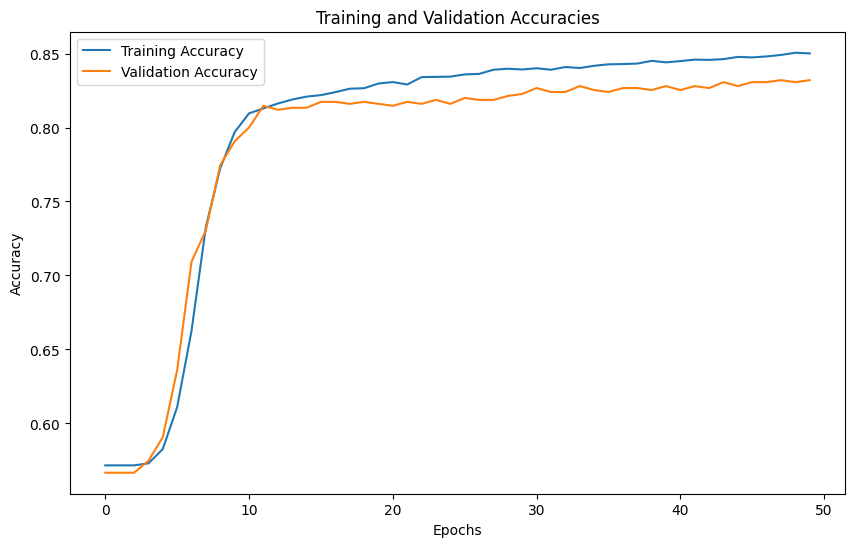

In [31]:
# Plot of the Accuracies

plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

In [32]:
# Save the Model
#model.save('disaster_prediction_model.h5')

### Testing

In [33]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Obtaining the embeddings for the text data

fine_tuned_model = SentenceTransformer("avsolatorio/GIST-large-Embedding-v0")

text_embeddings = []
for text in tqdm(df_test['text'].tolist(), total=len(df_test)):
    text_embeddings.append(fine_tuned_model.encode(text, convert_to_tensor=False))


df_test['text_embeddings'] = text_embeddings
print(df_test.info())

# Connect to the SQLite database
conn = sqlite3.connect('df_test_gist_large.db')
cursor = conn.cursor()

# Create the table with the specified columns
cursor.execute('''
    CREATE TABLE IF NOT EXISTS embeddings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        keyword TEXT,
        location TEXT,
        text TEXT,
        text_embeddings BLOB
    )
''')

conn.commit()

# Insert data into the table
for idx, (keyword, location, text, text_emb) in enumerate(zip(df_test['keyword'], df_test['location'], df_test['text'], text_embeddings)):
    text_emb_np = text_emb
    cursor.execute('''
        INSERT INTO embeddings (keyword, location, text, text_embeddings)
        VALUES (?, ?, ?, ?)
    ''', (keyword, location, text, text_emb_np.tobytes()))

conn.commit()
conn.close()

In [34]:
# Load the embeddings from the vector database
def load_embeddings(db_path):
    conn = sqlite3.connect(db_path)
    
    query = 'SELECT * FROM embeddings'
    result = conn.execute(query).fetchall()
    
    columns = ['id', 'keyword', 'location', 'text', 'text_embeddings']
    df = pd.DataFrame(result, columns=columns)
    
    df['text_embeddings'] = df['text_embeddings'].apply(lambda x: np.frombuffer(x, dtype=np.float32))
    
    conn.close()
    
    return df

db_path = 'df_test_gist_large.db'
testing_df = load_embeddings(db_path)
testing_df.head()

,id,keyword,location,text,text_embeddings
0,1,None,None,Just happened a terrible car crash,"[0.013861888, 0.057502873, -0.018154526, 0.022..."
1,2,None,None,"Heard about #earthquake is different cities, s...","[-0.022003504, 0.076746866, -0.045436904, 0.02..."
2,3,None,None,"there is a forest fire at spot pond, geese are...","[0.017565733, 0.033203896, 0.008968175, 0.0303..."
3,4,None,None,Apocalypse lighting. #Spokane #wildfires,"[0.012060357, 0.03152206, -0.041642085, 0.0360..."
4,5,None,None,Typhoon Soudelor kills 28 in China and Taiwan,"[-0.04631128, 0.022988748, 0.013771811, -0.024..."


In [35]:
# Convert text_embeddings to a NumPy array
embeddings = np.array(testing_df['text_embeddings'].tolist())

# Test the model
predictions = model.predict(embeddings)

# Apply a threshold to convert predictions to binary values
binary_predictions = (predictions > 0.5).astype(int)

# Create an empty DataFrame
predictions_df = pd.DataFrame()

# Map the original id from df_test to predictions_df
predictions_df['id'] = df_test['id']

# Merge with df_test to get the original id
predictions_df = predictions_df.merge(df_test[['id']], on='id', how='left')

# Add binary predictions to the DataFrame
predictions_df['target'] = binary_predictions

# Display the first few rows of predictions_df
predictions_df.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [37]:
count_0 = np.count_nonzero(predictions_df['target'] == 0)
count_1 = np.count_nonzero(predictions_df['target'] == 1)

print("Number of predictions that are 0:", count_0)
print("Number of predictions that are 1:", count_1)

Number of predictions that are 0: 2033
Number of predictions that are 1: 1230
